In [1]:
##2d plus time gaussian process
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator


In [2]:
def product_rbf_kernel_spacetime(coords1, coords2,
                                 ls_space=0.1, sigma_space=1.0,
                                 ls_time=0.1, sigma_time=1.0):
    """
    Product kernel for spatio-temporal data with separate RBF kernels:
      k((x,y,t),(x',y',t')) = k_space((x,y),(x',y')) * k_time(t,t').

    Parameters:
    -----------
    coords1 : array of shape (N, 3) = [ (x_i, y_i, t_i), ... ]
    coords2 : array of shape (M, 3) = [ (x_j, y_j, t_j), ... ]
    ls_space : float
        Length scale for the 2D (x,y) RBF.
    sigma_space : float
        Variance scale for the 2D (x,y) RBF.
    ls_time : float
        Length scale for the 1D time RBF.
    sigma_time : float
        Variance scale for the 1D time RBF.

    Returns:
    --------
    K : array of shape (N, M)
        Covariance matrix = k_product(coords1[i], coords2[j]).
    """
    # coords1, coords2: shape (N, 3), (M, 3)
    # Extract separate space/time components:
    xy1 = coords1[:, :2]  # (x,y)
    xy2 = coords2[:, :2]
    t1  = coords1[:, 2]   # t
    t2  = coords2[:, 2]

    # --- 1) Space kernel ---
    diff_xy = xy1[:, None, :] - xy2[None, :, :]  # shape (N, M, 2)
    dist_sq_xy = np.sum(diff_xy**2, axis=-1)     # shape (N, M)
    K_space = sigma_space**2 * np.exp(-0.5 * dist_sq_xy / ls_space**2)

    # --- 2) Time kernel ---
    diff_t = t1[:, None] - t2[None, :]           # shape (N, M)
    dist_sq_t = diff_t**2
    K_time = sigma_time**2 * np.exp(-0.5 * dist_sq_t / ls_time**2)

    # --- 3) Product ---
    K = K_space * K_time
    return K


In [3]:
def generate_gp_spatio_temporal_product(nx=30, ny=30, nt=10,
                                        ls_space=0.1, sigma_space=1.0,
                                        ls_time=0.1, sigma_time=1.0,
                                        random_state=None):
    """
    Generate a single sample from a spatio-temporal GP using a product kernel:
      K = K_space * K_time.

    Domain: x in [0,1], y in [0,1], t in [0,1].

    Parameters:
    -----------
    nx, ny, nt : int
        Number of grid points in x, y, t directions.
    ls_space, sigma_space : floats
        RBF kernel params for space. (x,y)
    ls_time, sigma_time : floats
        RBF kernel params for time (t).
    random_state : int or None
        Random seed for reproducibility.

    Returns:
    --------
    X, Y, T : 1D arrays
    F : 3D array (nx, ny, nt)
        Realization of the GP at each point (x_i, y_j, t_k).
    """
    if random_state is not None:
        np.random.seed(random_state)

    # 1. Define coordinate arrays
    X = np.linspace(0, 1, nx)
    Y = np.linspace(0, 1, ny)
    T = np.linspace(0, 1, nt)

    # Create a 3D mesh
    Xv, Yv, Tv = np.meshgrid(X, Y, T, indexing='ij')  # shape (nx, ny, nt)

    # Flatten
    coords = np.column_stack((Xv.ravel(), Yv.ravel(), Tv.ravel()))  # shape=(nx*ny*nt, 3)
    N = coords.shape[0]

    # 2. Covariance matrix via product kernel
    K = product_rbf_kernel_spacetime(coords, coords,
                                     ls_space=ls_space, sigma_space=sigma_space,
                                     ls_time=ls_time, sigma_time=sigma_time)

    # 3. Sample from MVN
    F_vec = np.random.multivariate_normal(mean=np.zeros(N), cov=K)

    # 4. Reshape
    F = F_vec.reshape((nx, ny, nt))
    return X, Y, T, F


F_true shape: (20, 20, 9)


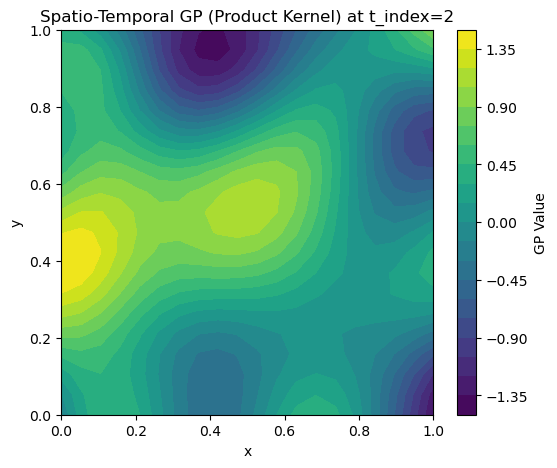

In [5]:

X, Y, T, F_true = generate_gp_spatio_temporal_product(
    nx=20, ny=20, nt=9,
    ls_space=0.2, sigma_space=1.0,
    ls_time=0.3,  sigma_time=0.8,
    random_state=42
)

print("F_true shape:", F_true.shape)  # (30, 30, 5)

# Plot the spatial field at a chosen time index
time_index = 2
plt.figure(figsize=(6,5))
plt.contourf(X, Y, F_true[:, :, time_index], levels=20, cmap='viridis')
plt.colorbar(label="GP Value")
plt.title(f"Spatio-Temporal GP (Product Kernel) at t_index={time_index}")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


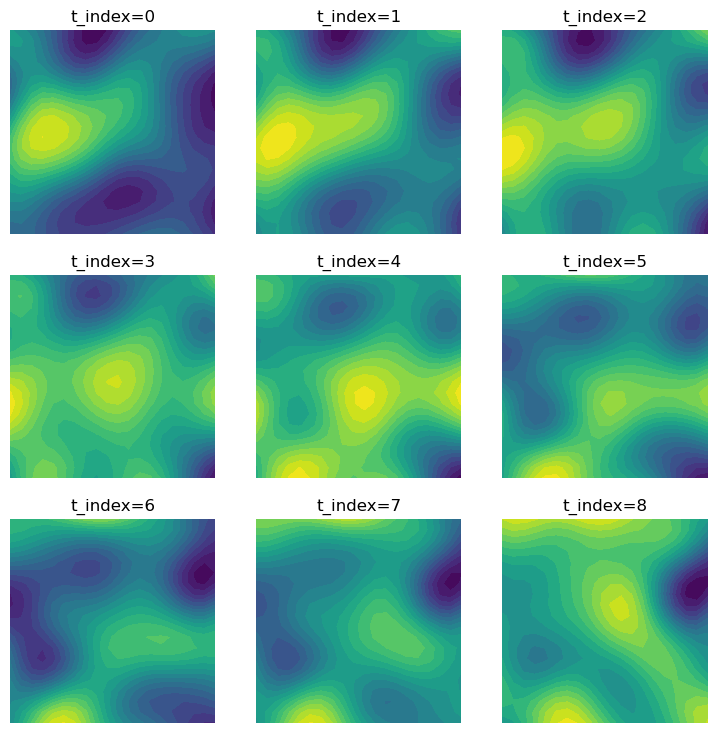

In [9]:
# Plot the spatial field at a chosen time index
#time_index = 1
plt.figure(figsize=(9,9))

for i in range(9):
    time_index = i
    plt.subplot(3,3,i+1)
    plt.contourf(X, Y, F_true[:, :, time_index], levels=20, cmap='viridis')
    plt.title(f"t_index={time_index}")
    plt.axis('off')



# plt.xlabel("x")
# plt.ylabel("y")
# plt.colorbar(label="GP Value")
plt.show()

In [ ]:
scaled = (F_true - np.mean(F_true))/np.std(F_true)

print(F_true)

In [26]:
print(np.mean(F_true))
print(np.std(F_true))

#May not need to standardise

-0.14733747116936138
0.6928047474340254


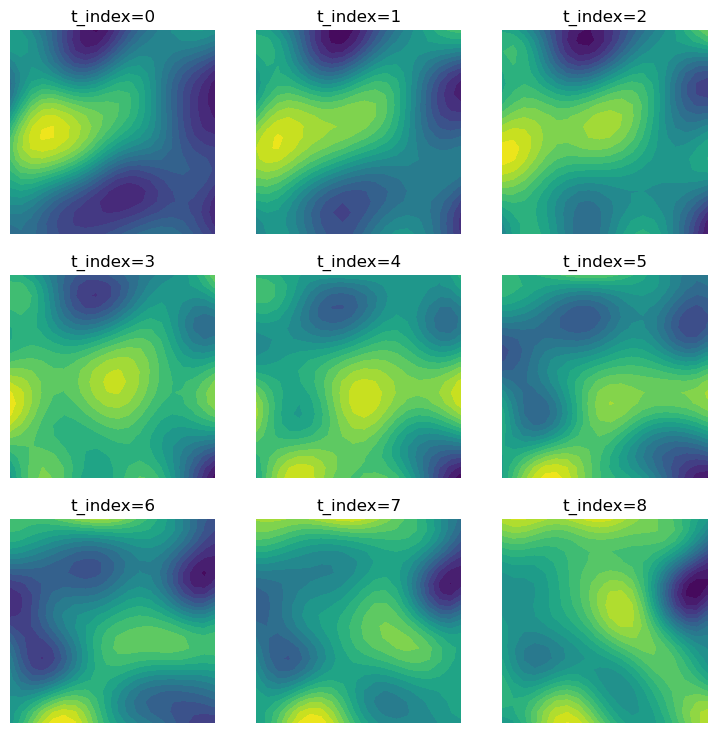

In [18]:
# Plot the spatial field at a chosen time index
#time_index = 1
plt.figure(figsize=(9,9))

for i in range(9):
    time_index = i
    plt.subplot(3,3,i+1)
    plt.contourf(X, Y, scaled[:, :, time_index], levels=20, cmap='viridis')
    plt.title(f"t_index={time_index}")
    plt.axis('off')

plt.show()

In [19]:
def add_noise_spatio_temporal(F_true, noise_std=0.1):
    """
    Add i.i.d. Gaussian noise to the entire 3D field.
    """
    noise = np.random.normal(0, noise_std, size=F_true.shape)
    return F_true + noise

def scale_amplitude_spatio_temporal(F_true, scale_factor=1.1):
    """
    Scale the entire 3D field by a constant factor.
    """
    return scale_factor * F_true

def time_shift_spatio_temporal(X, Y, T, F_true, shift=0.1):
    """
    Shift the data along the time dimension by 'shift'.
    Interpolate in (x,y,t) space, but only time changes.
    """
    F_interp = RegularGridInterpolator((X, Y, T), F_true,
                                       method='linear',
                                       bounds_error=False,
                                       fill_value=None)

    nx, ny, nt = F_true.shape
    T_shifted = T - shift

    Xv, Yv, Tv = np.meshgrid(X, Y, T_shifted, indexing='ij')
    coords_new = np.column_stack((Xv.ravel(), Yv.ravel(), Tv.ravel()))
    F_shifted_flat = F_interp(coords_new)
    F_shifted = F_shifted_flat.reshape((nx, ny, nt))
    return F_shifted

def space_shift_spatio_temporal(X, Y, T, F_true, shift_x=0.05, shift_y=0.05):
    """
    Shift the data in (x,y) domain by (shift_x, shift_y).
    """
    F_interp = RegularGridInterpolator((X, Y, T), F_true,
                                       method='linear',
                                       bounds_error=False,
                                       fill_value=None)

    nx, ny, nt = F_true.shape
    X_shifted = X - shift_x
    Y_shifted = Y - shift_y

    Xv, Yv, Tv = np.meshgrid(X_shifted, Y_shifted, T, indexing='ij')
    coords_new = np.column_stack((Xv.ravel(), Yv.ravel(), Tv.ravel()))
    F_shifted_flat = F_interp(coords_new)
    F_shifted = F_shifted_flat.reshape((nx, ny, nt))
    return F_shifted

def correlated_noise_spatio_temporal(X, Y, T, F_true,
                                     noise_ls_space=0.02, sigma_space=0.3,
                                     noise_ls_time=0.1, sigma_time=0.3):
    """
    Add spatio-temporal correlated noise drawn from another product kernel GP,
    then add to the original F_true.
    """
    nx, ny, nt = F_true.shape
    Xv, Yv, Tv = np.meshgrid(X, Y, T, indexing='ij')
    coords = np.column_stack((Xv.ravel(), Yv.ravel(), Tv.ravel()))

    # Construct the noise covariance
    K_noise = product_rbf_kernel_spacetime(coords, coords,
                                           ls_space=noise_ls_space,
                                           sigma_space=sigma_space,
                                           ls_time=noise_ls_time,
                                           sigma_time=sigma_time)
    noise_vec = np.random.multivariate_normal(mean=np.zeros(len(coords)), cov=K_noise)
    noise_field = noise_vec.reshape(F_true.shape)

    return F_true + noise_field


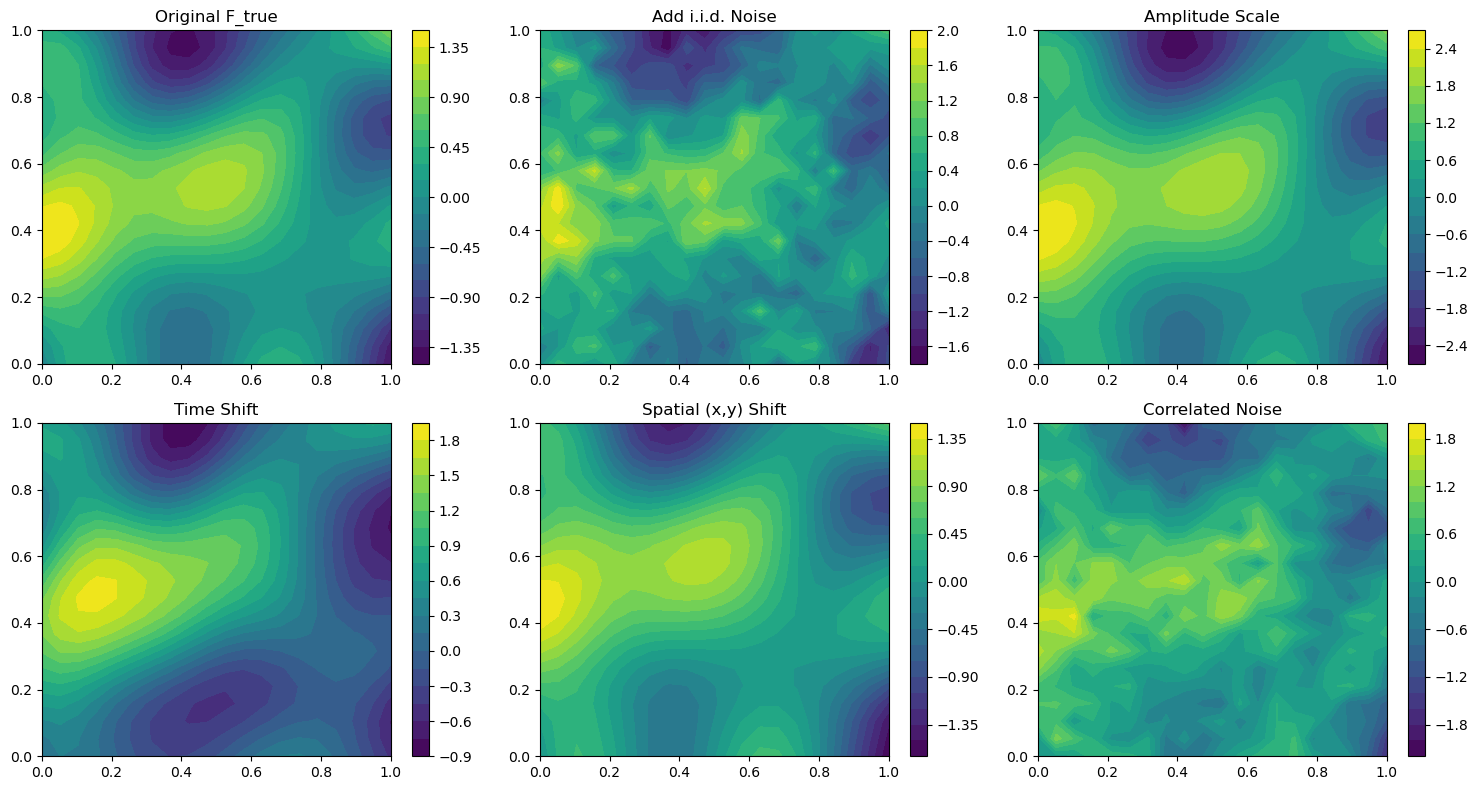

In [35]:

# 2. Create perturbations
F_noise    = add_noise_spatio_temporal(F_true, noise_std=0.3)
F_amp      = scale_amplitude_spatio_temporal(F_true, scale_factor=1.8)
F_tshift   = time_shift_spatio_temporal(X, Y, T, F_true, shift=0.2)
F_xyshift  = space_shift_spatio_temporal(X, Y, T, F_true, shift_x=0.05, shift_y=-0.03)
F_corr     = correlated_noise_spatio_temporal(X, Y, T, F_true,
                                                noise_ls_space=0.02, sigma_space=0.5,
                                                noise_ls_time=0.05, sigma_time=0.5)

# 3. Plot a single time slice for each
time_index = 2
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.ravel()

# Original
c0 = axs[0].contourf(X, Y, F_true[:, :, time_index], levels=20, cmap='viridis')
axs[0].set_title("Original F_true")
plt.colorbar(c0, ax=axs[0])

# Noise
c1 = axs[1].contourf(X, Y, F_noise[:, :, time_index], levels=20, cmap='viridis')
axs[1].set_title("Add i.i.d. Noise")
plt.colorbar(c1, ax=axs[1])

# Amplitude scale
c2 = axs[2].contourf(X, Y, F_amp[:, :, time_index], levels=20, cmap='viridis')
axs[2].set_title("Amplitude Scale")
plt.colorbar(c2, ax=axs[2])

# Time shift
c3 = axs[3].contourf(X, Y, F_tshift[:, :, time_index], levels=20, cmap='viridis')
axs[3].set_title("Time Shift")
plt.colorbar(c3, ax=axs[3])

# XY shift
c4 = axs[4].contourf(X, Y, F_xyshift[:, :, time_index], levels=20, cmap='viridis')
axs[4].set_title("Spatial (x,y) Shift")
plt.colorbar(c4, ax=axs[4])

# Correlated noise
c5 = axs[5].contourf(X, Y, F_corr[:, :, time_index], levels=20, cmap='viridis')
axs[5].set_title("Correlated Noise")
plt.colorbar(c5, ax=axs[5])

plt.tight_layout()
plt.show()


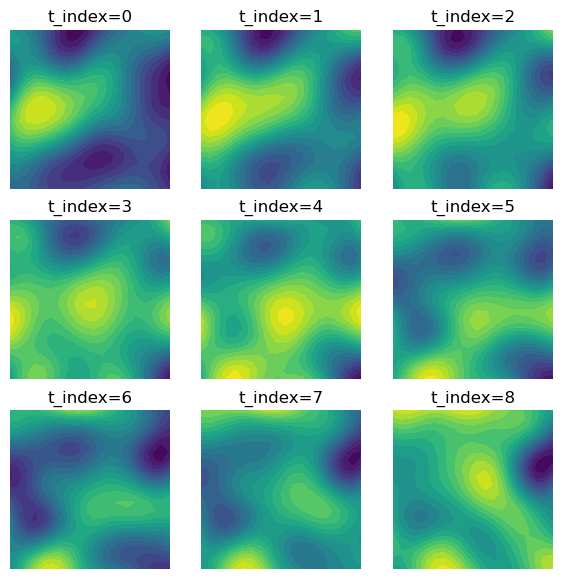

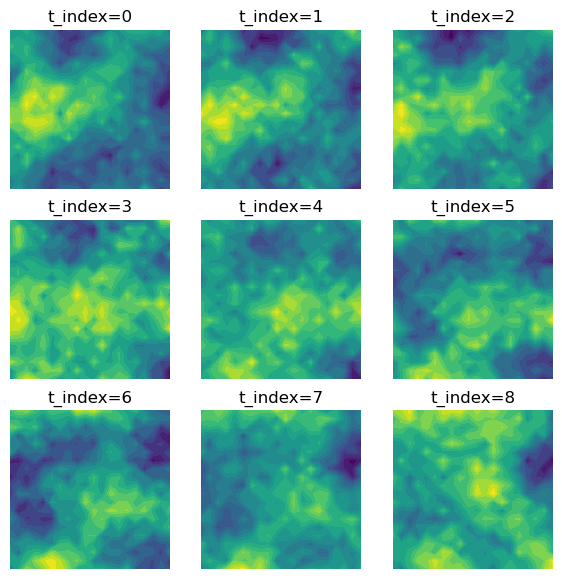

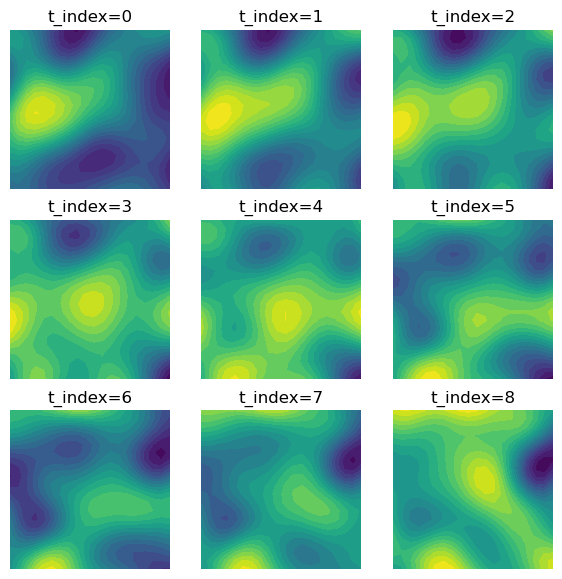

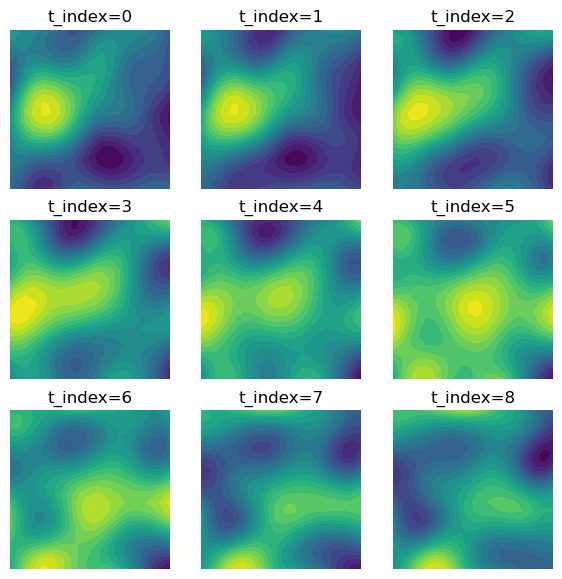

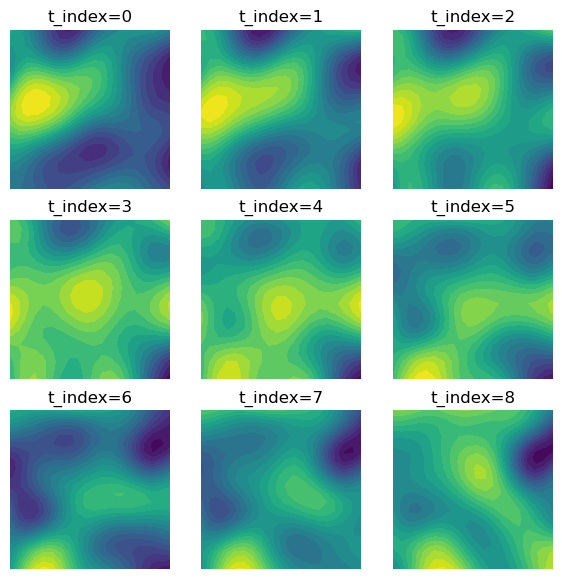

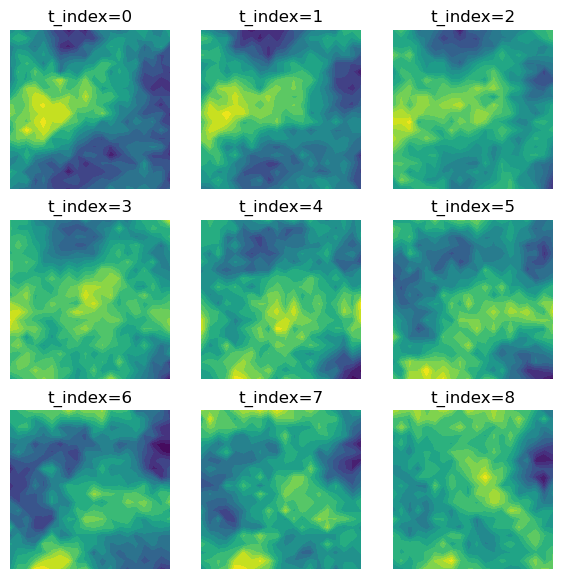

In [36]:
# Plot the spatial field at a chosen time index
#time_index = 1
plt.figure(figsize=(7,7))

for i in range(9):
    time_index = i
    plt.subplot(3,3,i+1)
    plt.contourf(X, Y, F_true[:, :, time_index], levels=20, cmap='viridis')
    plt.title(f"t_index={time_index}")
    plt.axis('off')

plt.show()

plt.figure(figsize=(7,7))
for i in range(9):
    time_index = i
    plt.subplot(3,3,i+1)
    plt.contourf(X, Y, F_noise[:, :, time_index], levels=20, cmap='viridis')
    plt.title(f"t_index={time_index}")
    plt.axis('off')

plt.show()

plt.figure(figsize=(7,7))
for i in range(9):
    time_index = i
    plt.subplot(3,3,i+1)
    plt.contourf(X, Y, F_amp[:, :, time_index], levels=20, cmap='viridis')
    plt.title(f"t_index={time_index}")
    plt.axis('off')

plt.show()

plt.figure(figsize=(7,7))
for i in range(9):
    time_index = i
    plt.subplot(3,3,i+1)
    plt.contourf(X, Y, F_tshift[:, :, time_index], levels=20, cmap='viridis')
    plt.title(f"t_index={time_index}")
    plt.axis('off')

plt.show()

plt.figure(figsize=(7,7))
for i in range(9):
    time_index = i
    plt.subplot(3,3,i+1)
    plt.contourf(X, Y, F_xyshift[:, :, time_index], levels=20, cmap='viridis')
    plt.title(f"t_index={time_index}")
    plt.axis('off')

plt.show()

plt.figure(figsize=(7,7))
for i in range(9):
    time_index = i
    plt.subplot(3,3,i+1)
    plt.contourf(X, Y, F_corr[:, :, time_index], levels=20, cmap='viridis')
    plt.title(f"t_index={time_index}")
    plt.axis('off')

plt.show()

In [37]:
## Try with pertubations, but then have start conditions, predict out with gaussain process with different parameters? then compare??
F_true

array([[[ 0.19098165,  0.14547902, -0.1366035 , ..., -0.43796051,
         -0.36464588, -0.29717786],
        [ 0.24604403,  0.38245494,  0.22491788, ..., -0.08632658,
         -0.11971675, -0.18909885],
        [ 0.17986442,  0.45846565,  0.43086113, ...,  0.32319832,
          0.22492099,  0.03837961],
        ...,
        [-0.01917874, -0.13289013, -0.59655729, ..., -1.43924323,
         -0.48581385,  0.41619514],
        [-0.18162839, -0.42585788, -0.98973581, ..., -1.52112405,
         -0.41155462,  0.63712291],
        [-0.3381536 , -0.71735601, -1.3573221 , ..., -1.52893776,
         -0.35472966,  0.76119447]],

       [[ 0.27305609,  0.2516049 , -0.00808152, ..., -0.43196907,
         -0.26980686, -0.07328825],
        [ 0.30182557,  0.42923624,  0.27561558, ..., -0.19757297,
         -0.1314666 , -0.04066505],
        [ 0.20711155,  0.45112058,  0.42112002, ...,  0.11532406,
          0.11629274,  0.10524015],
        ...,
        [-0.1140288 , -0.15392185, -0.5476755 , ..., -

In [41]:
def reorganise(orgdata):
    # 1) Move the time axis (currently last) to the middle:
    #    We want shape (9, 20, 20) so time is first (like length dimension)
    F_tfirst = np.moveaxis(orgdata, -1, 0)  # shape becomes (9, 20, 20)

    # 2) Flatten the spatial dimensions (20,20) into a single dimension (400):
    F_flat = F_tfirst.reshape(9, -1)  # shape (9, 400)

    # 3) Add a batch dimension of size 1
    F_batch = F_flat[None, ...]  # shape (1, 9, 400)

    print("Final shape for sigkernel:", F_batch.shape)

    return F_batch



In [43]:
Ftrueorg = reorganise(F_true)
Fnoiseorg = reorganise(F_noise)
Famporg = reorganise(F_amp)
Ftshiftorg = reorganise(F_tshift)
Fxyshiftorg = reorganise(F_xyshift)
Fcorrorg = reorganise(F_corr)

Final shape for sigkernel: (1, 9, 400)
Final shape for sigkernel: (1, 9, 400)
Final shape for sigkernel: (1, 9, 400)
Final shape for sigkernel: (1, 9, 400)
Final shape for sigkernel: (1, 9, 400)
Final shape for sigkernel: (1, 9, 400)


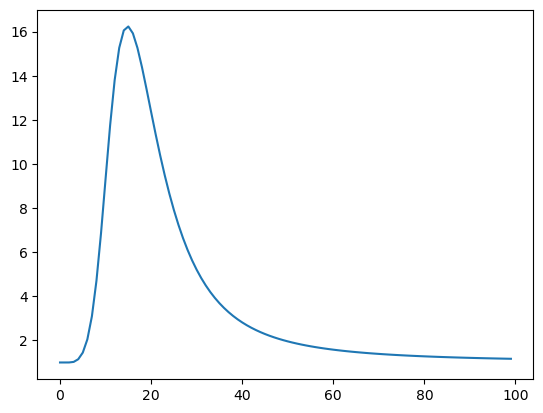

In [86]:
import sigkernel
import torch



static_kernel = sigkernel.RBFKernel(sigma=0.5)
dyadic_order = 1
max_batch = 100
signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)

#Sqrt dimension is a good idea
#Some interesting plots
vals = np.zeros(100)
for val in range(100):
    val = val+1
    X = torch.tensor(Fnoiseorg, device = "cpu")/val#[:,:,:100]
    Y = torch.tensor(Ftrueorg, device = "cpu")/val#[:,:,:100]
    vals[val-1] = (signature_kernel.compute_Gram(X,Y,max_batch))
plt.plot(vals)

# # Compute signature kernel "batch-wise" (i.e. k(x_1,y_1),...,k(x_batch, y_batch))
# K = signature_kernel.compute_kernel(X,Y,max_batch)

# # Compute signature kernel Gram matrix (i.e. k(x_i,y_j) for i,j=1,...,batch), also works for different batch_x != batch_y)
# G = signature_kernel.compute_Gram(X,Y,sym=False,max_batch)

# # Compute MMD distance between samples x ~ X and samples y ~ Y, where X,Y are two distributions on path space...
# mmd = signature_kernel.compute_mmd(X,Y,max_batch)
# # ... and to backpropagate through the MMD distance simply call .backward(), like any other PyTorch loss function
# mmd.backward()

# # Compute scoring rule between X and a sample path y, i.e. S_sig(X,y) = E[k(X,X)] - 2E[k(X,y] ...
# y = Y[0]
# sr = signature_kernel.compute_scoring_rule(X,y,max_batch)

# # ... and expected scoring rule between X and Y, i.e. S(X,Y) = E_Y[S_sig(X,y)]
# esr = signature_kernel.compute_expected_scoring_rule(X,Y,max_batch)

# # Sig CHSIC: XY|Z
# sigchsic = signature_kernel.SigCHSIC(X, Y, Z, static_kernel, dyadic_order=1, eps=0.1)